# Stories frames and analysis of multiple documents

<div class="alert alert-block alert-warning">
This example notebook is still under construction.
<div>

In [1]:
import re
from pathlib import Path
import pickle
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spacy
from segram import Corpus, Story

# Use GPU acceleration for parsing documents if available
spacy.prefer_gpu()

# Paths
HERE = Path(".").absolute()
DATA = HERE/"data"

# Read dataset of articles coveriing the war in Syria
data = pd.read_csv(DATA/"FA-KES-Dataset.csv", encoding="latin")

# Sanitize beginnings of content strings to get rid of publication dates
# and other metadata. This is done using a few regular expressions
#
# Get rid of publication dates
pattern1 = r"^(" \
    r"\s*([A-Z]\w+)?\s*\d{1,2}\s*([A-Z]\w+)?\s*\d{2,4}\s*" \
    r"|" \
    r"\d{1,2}[-\.]\d{1,2}[-\.]\d{2,4}\s*" \
    r")" \
    r"(\s*at\s*\d+:?\d+)?"
# Get rid of update dates
pattern2 = r"^\s*(\(updated\s*[\w\d]*\s*\))\s*"
# Get rid of get url shout outs
pattern3 = r"^\s*get\s*short\s*url\s*([\d\w]+\s*)*"
pattern4 = r"^Date\s*of\s*publication\s*\d{1,2}\s*\w+\s*\d{2,4}\s*"

# Sanitize the content column
data["article_content"] = data["article_content"] \
    .str.replace(pattern1, r"", regex=True) \
    .str.replace(pattern2, r"", regex=True, flags=re.IGNORECASE) \
    .str.replace(pattern3, r"", regex=True, flags=re.IGNORECASE) \
    .str.replace(pattern4, r"", regex=True, flags=re.IGNORECASE) \
    .str.strip()

In [2]:
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("segram", config={
    "vectors": "en_core_web_lg"
})
nlp.add_pipe("segram_coref")

## Prepare data

### Titles

In [3]:
%%time
fpath = DATA/"titles.segram"

if fpath.exists():
    titles = Corpus.from_disk(fpath, vocab=nlp.vocab, progress=True)
else:
    texts = data["article_title"]
    titles = Corpus.from_texts(nlp, *texts, progress=True, tqdm_kws={
        "total": len(texts)
    })
    titles.to_disk(fpath, nlp=False, vocab=False)

# Make sure word vectors are stored on CPU after parsing
# this is usually desirable when using semantic similarity methods
titles = Story(titles)

  0%|          | 0/774 [00:00<?, ?it/s]

CPU times: user 6.9 s, sys: 107 ms, total: 7 s
Wall time: 6.97 s


### Articles

In [4]:
# %%time
# fpath = DATA/"articles.segram"
# if fpath.exists():
#     articles = Corpus.from_disk(fpath, vocab=nlp.vocab, progress=True)
# else:
#     texts = data["article_content"]
#     articles = Corpus.from_texts(nlp, *texts, progress=True, tqdm_kws={
#             "total": len(texts)
#         })
#     articles.to_disk(fpath, nlp=False, vocab=False)
# # Make sure word vectors are stored on CPU after parsing
# # this is usually desirable when using semantic similarity methods
# articles = Story(articles)

## Analysis

In [5]:
# Move word vectors to CPU
# since this is more optimal for structured similarity methods
titles.corpus.ensure_cpu_vectors()
# articles.corpus.ensure_cpu_vectors()

### Titles

In [12]:
%%time
fpath = DATA/"titles.pkl"

if fpath.exists():
    with open(fpath, "rb") as fh:
        S = pickle.load(fh)
else:
    story = titles
    n_sents = sum(len(doc.smap) for doc in story.docs)
    S = np.zeros((n_sents, n_sents), dtype=float)
    for i, si in tqdm(enumerate(story.sents), total=n_sents):
        for j, sj in enumerate(story.sents[:i]):
            S[i, j] = si.similarity(sj, method="phrases")
    S += S.T
    np.fill_diagonal(S, 1)
    S = (S + S.T) / 2
    with open(fpath, "wb") as fh:
        pickle.dump(S, fh)


L, V = np.linalg.eigh(S)
L = np.diag(np.clip(L, 0, None)[::-1])
V = V[:, ::-1]
Z = (V@np.sqrt(L))[:, :2]
var_explained = L.diagonal() / L.diagonal().sum()

CPU times: user 1.99 s, sys: 47 ms, total: 2.03 s
Wall time: 410 ms


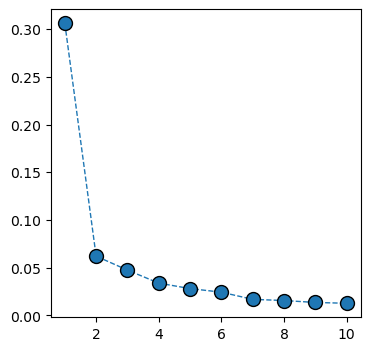

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

var = var_explained[:10]
ax.plot(
    np.arange(1, len(var)+1), var,
    marker="o", markersize=10, markeredgecolor="black",
    ls="--", lw=1
)

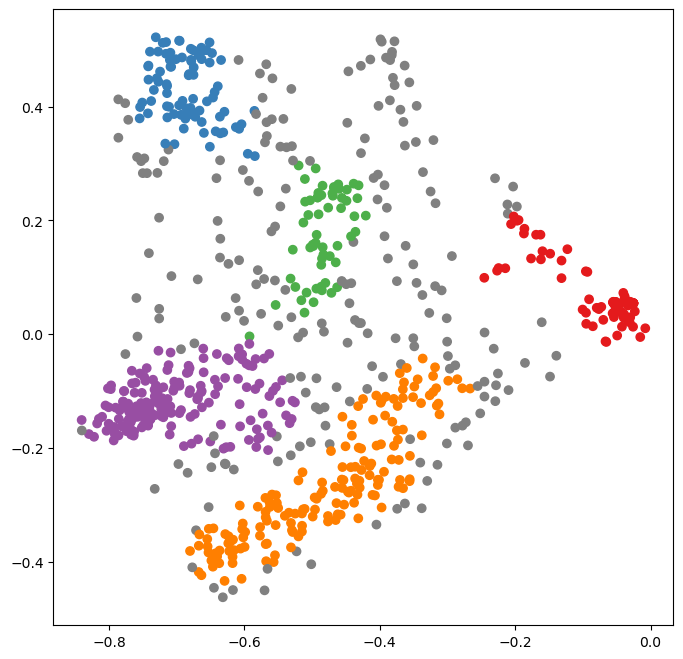

In [16]:
from itertools import groupby
import numpy as np
from hdbscan import HDBSCAN

story  = titles
hdb    = HDBSCAN(min_cluster_size=20)
labels = hdb.fit_predict(Z)

cmap = plt.cm.Set1
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(*Z.T, color=[ "gray" if l == -1 else cmap(l) for l in labels ])

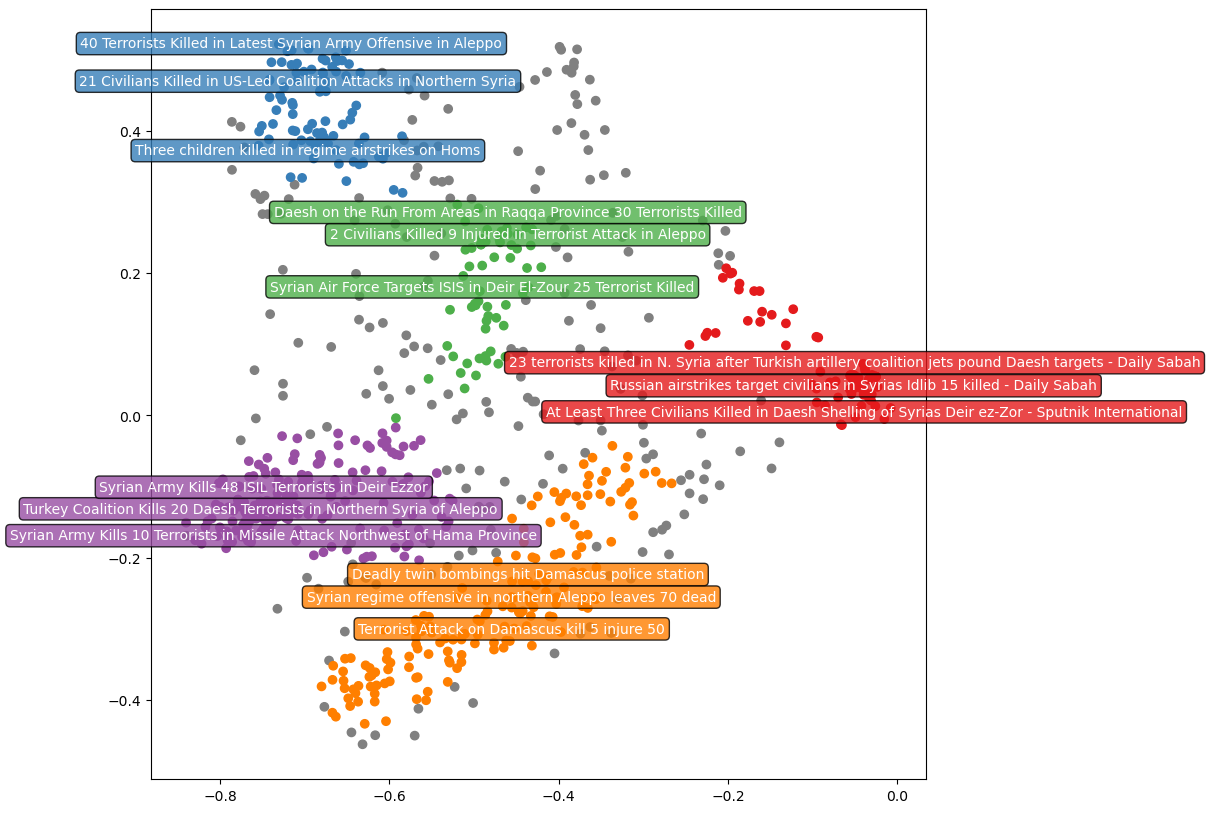

In [36]:
probs   = hdb.probabilities_
order   = np.argsort(probs)
oprobs  = probs[order]
osents  = tuple(story.sents[i] for i in order)
olabels = labels[order] 
Z_ord   = Z[order]

topics = {}
for label, sent, xy in zip(olabels, osents, Z_ord):
    topics.setdefault(label, []).append((sent, xy))

cmap = plt.cm.Set1
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*Z_ord.T, color=[ "gray" if l == -1 else cmap(l) for l in olabels ])

tkws = dict(fontsize=10, ha="center", va="center", color="white")
for topic, sents in topics.items():
    if topic == -1:
        continue
    bbox = dict(boxstyle="round", facecolor=cmap(topic), alpha=.8)
    best = sents[-3:]
    best_sents = tuple(x[0] for x in best)
    X, Y = np.array([ x[1] for x in best]).T
    Y[Y == Y.min()] -= .03
    Y[Y == Y.max()] += .03
    for sent, x, y in zip(best_sents, X, Y):
        ax.text(x, y, sent.text, bbox=bbox, **tkws)

### Articles

In [9]:
# %%time
# fpath = DATA/"articles.pkl"

# if fpath.exists():
#     with open(fpath, "rb") as fh:
#         S = pickle.load(fh)
# else:
#     story = articles
#     n_sents = sum(len(doc.smap) for doc in story.docs)
#     S = np.zeros((n_sents, n_sents), dtype=float)
#     for i, si in tqdm(enumerate(story.sents), total=n_sents):
#         for j, sj in enumerate(story.sents[:i]):
#             S[i, j] = si.similarity(sj, method="phrases")
#     S += S.T
#     np.fill_diagonal(S, 1)
#     S = (S + S.T) / 2
#     with open(fpath, "wb") as fh:
#         pickle.dump(S, fh)


# L, V = np.linalg.eigh(S)
# L = np.diag(np.clip(L, 0, None)[::-1])
# V = V[:, ::-1]
# Z = (V@np.sqrt(L))[:, :2]
# var_explained = L.diagonal() / L.diagonal().sum()